In [21]:
import sys
import os
import pandas
import copy
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import IaFreqDistAnalysis

# Read pair types

In paired-end sequencing, four different read pairs can be distinguished after mapping:

1. The reads are mapped onto different strands and point to each other (`S1`)
2. The reads are mapped onto different strands and point away from each other (`S2`)
3. The reads both are mapped to the reverse strand (`T1`)
3. The reads both are mapped to the forward strand (`T2`)

Type `S1` read pairs typically occur in paired-end sequencing of fragmented DNA. Due to the re-ligation step, the other three read pair types (`S2`, `T1`, `T2`) occur with Hi-C. The aim of this notebook is to examine the overall frequencies with which the four read pair types occur in Hi-C and capture Hi-C data.

## Loading interaction data

We analyzed a large dataset containing Hi-C (`HC`) and capture Hi-C data (`CHC`). There are Hi-C datasets for eight different celltypes:
```
MK, ERY, NEU, MON, MAC_M0, NB, NCD4, NCD8
```
We also created a dataset by pooling the Hi-C datasets for all eight cell types. To load this dataset, set `PROTOCOL=HC_POOLED`.

Furthermore, there are capture Hi-C datasets for 17 celltypes:
```
MK, ERY, NEU, MON, MAC_M0, MAC_M1, MAC_M2, EP, NB, TB, FOET, NCD4, TCD4, NACD4, ACD4, NCD8, TCD8
```

For the Hi-C datasets of individual celltypes, there is data for the minimum interaction distances `5,000`,`10,000` and `20,000`. For the pooled Hi-C and capture Hi-C datasets, there is only data for a minimum interaction distance of `20,000`.

The code in the following cell can be used to load an interaction set for a specific protocol, cell type and interaction distance.

In [20]:
PROTOCOL = 'CHC'
CELL_TYPE_SHORT = 'MK'
MIN_I_DIST = '20000'
if PROTOCOL == 'CHC':
    MIN_I_DIST = '20000'
RPC_RULE = 'ht'
FDR = '05'
if PROTOCOL == 'CHC':
    INTERACTION_FILE = '../DICer_interactions/' + RPC_RULE.upper() + '/FDR0' + FDR + '/CHC/JAV_' + CELL_TYPE_SHORT + '_RALT_20000_' + RPC_RULE + '_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + CELL_TYPE_SHORT + '_CHC_RALT_' + MIN_I_DIST + '_' + RPC_RULE.lower()
if PROTOCOL == 'HC_POOLED':
    INTERACTION_FILE = '../DICer_interactions/HT/FDR005/HC/20000/JAV_ALL_HC_RALL_ALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + 'POOLED_HC_FDR005' + '_HC_RALT_20000_' + RPC_RULE.lower()
if PROTOCOL == 'HC':
    INTERACTION_FILE = '../DICer_interactions/' + RPC_RULE.upper() + '/FDR0' + FDR + '/HC/' + MIN_I_DIST + '/JAV_' + CELL_TYPE_SHORT + '_HC_RALT_' + MIN_I_DIST + '_' + RPC_RULE + '_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + CELL_TYPE_SHORT + '_HC_RALT_'  + MIN_I_DIST + '_' + RPC_RULE.lower()

# Create DiachromaticInteractionSet
d11_interaction_set = DiachromaticInteractionSet(rpc_rule = RPC_RULE)
d11_interaction_set.parse_file(
    i_file = INTERACTION_FILE,
    verbose = True)

# Pass the DiachromaticInteractionSet to IaFreqDistAnalysis
ia_freq_dist_analysis = IaFreqDistAnalysis()
report_dict = ia_freq_dist_analysis.ingest_interaction_set(
    d11_inter_set = d11_interaction_set,
    verbose = True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../DICer_interactions/HT/FDR005/HC/20000/JAV_ALL_HC_RALL_ALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Parsed 2,000,000 interaction lines ...
	[INFO] Parsed 3,000,000 interaction lines ...
	[INFO] Parsed 4,000,000 interaction lines ...
	[INFO] Parsed 5,000,000 interaction lines ...
	[INFO] Set size: 5,332,493
[INFO] ... done.
[INFO] Reading interactions and group them according to chromosomes, interaction and enrichment category ...
	[INFO] Read 1,000,000 interactions ...
	[INFO] Read 2,000,000 interactions ...
	[INFO] Read 3,000,000 interactions ...
	[INFO] Read 4,000,000 interactions ...
	[INFO] Read 5,000,000 interactions ...
	[INFO] Total number of interactions read: 5,332,493
[INFO] ... done.


In addition to reading in the interactions, the interaction are also grouped so that the various categories can be output for control purposes.

In [3]:
print(ia_freq_dist_analysis.get_ingest_interaction_set_info_report())

[INFO] Report on ingestion of interactions:
	[INFO] Total number of interactions read: 10,189,595
	[INFO] Broken down by interaction category and enrichment status: 
		[INFO] DIX: 
			[INFO] NN: 19,409
			[INFO] EE: 68,742
			[INFO] NE: 664,212
			[INFO] EN: 669,443
		[INFO] DI: 
			[INFO] NN: 115,886
			[INFO] EE: 148,017
			[INFO] NE: 1,706,596
			[INFO] EN: 1,710,830
		[INFO] DI_S: 
			[INFO] NN: 2,760
			[INFO] EE: 2,506
			[INFO] NE: 23,374
			[INFO] EN: 23,367
		[INFO] DI_T: 
			[INFO] NN: 2,641
			[INFO] EE: 3,535
			[INFO] NE: 21,406
			[INFO] EN: 21,301
		[INFO] UIR: 
			[INFO] NN: 115,886
			[INFO] EE: 148,017
			[INFO] NE: 1,710,811
			[INFO] EN: 1,706,615
		[INFO] UI: 
			[INFO] NN: 193,982
			[INFO] EE: 118,366
			[INFO] NE: 547,343
			[INFO] EN: 545,440
		[INFO] ALL: 
			[INFO] NN: 445,163
			[INFO] EE: 483,142
			[INFO] NE: 4,628,962
			[INFO] EN: 4,632,328
[INFO] End of report.



## Counting read pair types in the various categories

In [4]:
RP_TYPE_FREQ_DICT = {
    'DIX':{
        'NN': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'EE': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'NE': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'EN': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'ALL': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0}
    },
    'DI':{
        'NN': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'EE': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'NE': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'EN': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'ALL': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0}  
    },
    'UIR':{
        'NN': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'EE': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'NE': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'EN': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'ALL': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0}
    },
    'UI':{
        'NN': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'EE': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'NE': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'EN': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'ALL': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0}    
    },
    'ALL':{
        'NN': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'EE': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'NE': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'EN': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0},
        'ALL': {'S1': 0, 'S2': 0, 'T1': 0, 'T2': 0}    
    }
}
for d11_inter in d11_interaction_set.interaction_list:
    
    # Get tags for interaction and enrichment category
    i_cat = d11_inter.get_category()
    e_cat = d11_inter.enrichment_status_tag_pair
    
    # Counts within each category
    RP_TYPE_FREQ_DICT[i_cat][e_cat]['S1'] += d11_inter._simple_1
    RP_TYPE_FREQ_DICT[i_cat][e_cat]['S2'] += d11_inter._simple_2
    RP_TYPE_FREQ_DICT[i_cat][e_cat]['T1'] += d11_inter._twisted_1
    RP_TYPE_FREQ_DICT[i_cat][e_cat]['T2'] += d11_inter._twisted_2
    
    # Counts combined for interaction categories
    RP_TYPE_FREQ_DICT['ALL'][e_cat]['S1'] += d11_inter._simple_1
    RP_TYPE_FREQ_DICT['ALL'][e_cat]['S2'] += d11_inter._simple_2
    RP_TYPE_FREQ_DICT['ALL'][e_cat]['T1'] += d11_inter._twisted_1
    RP_TYPE_FREQ_DICT['ALL'][e_cat]['T2'] += d11_inter._twisted_2
    
    # Counts combined for enrichment categories
    RP_TYPE_FREQ_DICT[i_cat]['ALL']['S1'] += d11_inter._simple_1
    RP_TYPE_FREQ_DICT[i_cat]['ALL']['S2'] += d11_inter._simple_2
    RP_TYPE_FREQ_DICT[i_cat]['ALL']['T1'] += d11_inter._twisted_1
    RP_TYPE_FREQ_DICT[i_cat]['ALL']['T2'] += d11_inter._twisted_2
    
    # Counts combined for interaction and enrichment categories
    RP_TYPE_FREQ_DICT['ALL']['ALL']['S1'] += d11_inter._simple_1
    RP_TYPE_FREQ_DICT['ALL']['ALL']['S2'] += d11_inter._simple_2
    RP_TYPE_FREQ_DICT['ALL']['ALL']['T1'] += d11_inter._twisted_1
    RP_TYPE_FREQ_DICT['ALL']['ALL']['T2'] += d11_inter._twisted_2


# Fill second dictionary with realtive frequencies
RP_TYPE_DENS_DICT = copy.deepcopy(RP_TYPE_FREQ_DICT)
for i_cat in ['DIX','DI','UIR','UI','ALL']:
    for e_cat in ['NN','EE','NE','EN','ALL']:
        rp_total = sum(RP_TYPE_FREQ_DICT[i_cat][e_cat].values())
        if 0 < rp_total:
            RP_TYPE_DENS_DICT[i_cat][e_cat]['S1'] = RP_TYPE_FREQ_DICT[i_cat][e_cat]['S1']/rp_total
            RP_TYPE_DENS_DICT[i_cat][e_cat]['S2'] = RP_TYPE_FREQ_DICT[i_cat][e_cat]['S2']/rp_total
            RP_TYPE_DENS_DICT[i_cat][e_cat]['T1'] = RP_TYPE_FREQ_DICT[i_cat][e_cat]['T1']/rp_total
            RP_TYPE_DENS_DICT[i_cat][e_cat]['T2'] = RP_TYPE_FREQ_DICT[i_cat][e_cat]['T2']/rp_total
        else:
            RP_TYPE_DENS_DICT[i_cat][e_cat]['S1'] = 0.0
            RP_TYPE_DENS_DICT[i_cat][e_cat]['S2'] = 0.0
            RP_TYPE_DENS_DICT[i_cat][e_cat]['T1'] = 0.0
            RP_TYPE_DENS_DICT[i_cat][e_cat]['T2'] = 0.0

Output read pair type counts and relative frequencies for specific enrichment category. Use `ALL` to output the combined counts from all enrichment categories.

In [5]:
e_cat = 'ALL'
for i_cat in ['DIX','DI','UIR','UI','ALL']:
    print(i_cat + '-' + e_cat)
    print(RP_TYPE_FREQ_DICT[i_cat][e_cat])
    print(RP_TYPE_DENS_DICT[i_cat][e_cat])

DIX-ALL
{'S1': 31809760, 'S2': 26079711, 'T1': 30653435, 'T2': 26938917}
{'S1': 0.27545252727782105, 'S2': 0.2258339046137157, 'T1': 0.26543947959671543, 'T2': 0.23327408851174786}
DI-ALL
{'S1': 15996320, 'S2': 14695010, 'T1': 16598251, 'T2': 14111430}
{'S1': 0.26052209466062376, 'S2': 0.2393284696892043, 'T1': 0.27032536972396104, 'T2': 0.22982406592621088}
UIR-ALL
{'S1': 15441634, 'S2': 15240740, 'T1': 15572010, 'T2': 15146627}
{'S1': 0.25148826946839686, 'S2': 0.24821643409096308, 'T1': 0.25361162212785066, 'T2': 0.2466836743127894}
UI-ALL
{'S1': 2619002, 'S2': 2564203, 'T1': 2648587, 'T2': 2550436}
{'S1': 0.2522581858152219, 'S2': 0.2469800316463865, 'T1': 0.2551077668492736, 'T2': 0.245654015689118}
ALL-ALL
{'S1': 65866716, 'S2': 58579664, 'T1': 65472283, 'T2': 58747410}
{'S1': 0.2648801873346027, 'S2': 0.2355756187133739, 'T1': 0.26329399185871244, 'T2': 0.2362502020933109}


Output all absolute frequencies (`PRINT_FREQS = True`) or relative frequencies (`PRINT_FREQS = False`) in a formatted way.

In [6]:
PRINT_FREQS = False
for i_cat in ['DIX', 'DI', 'UIR', 'UI', 'ALL']:
    print(i_cat)
    print('\t', end='')
    for e_cat in ['S1', 'S2', 'T1', 'T2']:
        print('\t' + e_cat, end='')
    print()
    for e_cat in ['NN', 'EE', 'NE', 'EN', 'ALL']:
        print('\t' + e_cat + ': ', end='')
        for ht_tag in ['S1', 'S2', 'T1', 'T2']:
            if PRINT_FREQS:
                print('\t' + "{:,}".format(RP_TYPE_FREQ_DICT[i_cat][e_cat][ht_tag]), end='')
            else:
                print('\t' + "{:.2f}".format(RP_TYPE_DENS_DICT[i_cat][e_cat][ht_tag]), end='')
        print()

DIX
		S1	S2	T1	T2
	NN: 	0.27	0.23	0.12	0.39
	EE: 	0.28	0.22	0.26	0.25
	NE: 	0.25	0.25	0.25	0.24
	EN: 	0.30	0.21	0.28	0.22
	ALL: 	0.28	0.23	0.27	0.23
DI
		S1	S2	T1	T2
	NN: 	0.28	0.23	0.20	0.30
	EE: 	0.26	0.23	0.26	0.25
	NE: 	0.24	0.26	0.27	0.23
	EN: 	0.28	0.22	0.28	0.22
	ALL: 	0.26	0.24	0.27	0.23
UIR
		S1	S2	T1	T2
	NN: 	0.26	0.24	0.23	0.27
	EE: 	0.25	0.24	0.26	0.25
	NE: 	0.25	0.25	0.25	0.25
	EN: 	0.26	0.24	0.25	0.25
	ALL: 	0.25	0.25	0.25	0.25
UI
		S1	S2	T1	T2
	NN: 	0.26	0.24	0.24	0.26
	EE: 	0.25	0.24	0.26	0.25
	NE: 	0.24	0.26	0.26	0.24
	EN: 	0.26	0.24	0.26	0.24
	ALL: 	0.25	0.25	0.26	0.25
ALL
		S1	S2	T1	T2
	NN: 	0.27	0.23	0.20	0.29
	EE: 	0.26	0.23	0.26	0.25
	NE: 	0.25	0.25	0.26	0.24
	EN: 	0.28	0.22	0.27	0.23
	ALL: 	0.26	0.24	0.26	0.24


Plot frequencies of read pair types for specific enrichment category. Use `ALL` to plot the combined frequencies from all enrichment categories.

ToDo
- Stucture code and write function and write it into a function
- Check second y-axis

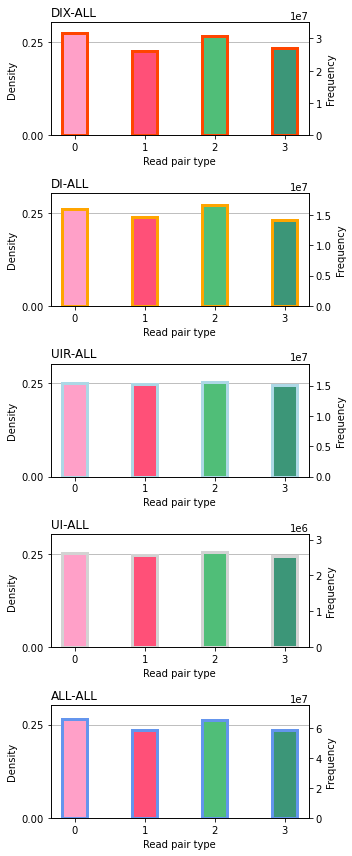

In [7]:
pdf_file_name = OUT_PREFIX + '_rpt.pdf'
e_cat = 'ALL'

RP_CAT_COLORS = [(255/255, 160/255, 200/255), (255/255, 80/255, 120/255), (80/255, 190/255, 120/255), (60/255, 150/255, 120/255)]
I_CAT_COLORS = {
    'DIX': 'orangered',
    'DI': 'orange',
    'UIR': 'lightblue',
    'UI': 'lightgray',
    'ALL': 'cornflowerblue'
}
rp_cat_labels = ['0', '1', '2', '3']

# Determine y_max
y_max_d = 0.25
for i_cat in ['DIX', 'DI', 'UIR', 'UI', 'ALL']:
    if y_max_d < max(RP_TYPE_DENS_DICT[i_cat][e_cat].values()):
        y_max_d = max(RP_TYPE_DENS_DICT[i_cat][e_cat].values())
y_max_d = y_max_d + y_max_d/10


x = np.arange(len(rp_cat_labels))  # the label locations
width = 0.35  # the width of the bars
density_tick_labels = np.arange(0, 1, 0.25)

fig, ax = plt.subplots(5, figsize=(5,12))

row_idx = 0
for i_cat in ['DIX', 'DI', 'UIR', 'UI', 'ALL']:
    
    # Create barchart
    ax[row_idx].bar(x, RP_TYPE_DENS_DICT[i_cat][e_cat].values(), width, color=RP_CAT_COLORS)
    ax[row_idx].set_title(i_cat + '-' + e_cat, loc='left')
    ax[row_idx].set_xticks(x)
    ax[row_idx].set_xticklabels(rp_cat_labels)
    ax[row_idx].axhline(0.25, zorder=0, color='gray', linewidth=0.5)
    ax[row_idx].set_xlabel('Read pair type')
    ax[row_idx].set_ylabel('Density')
    ax[row_idx].set_yticks(ticks=density_tick_labels)
    
    # Add second axis with absolute counts and normalize to maximum density
    ax2 = ax[row_idx].twinx()
    ax2.bar(x, RP_TYPE_FREQ_DICT[i_cat][e_cat].values(), width, color=RP_CAT_COLORS, edgecolor=I_CAT_COLORS[i_cat], linewidth=3)
    ax2.set_ylabel('Frequency')
    ax[row_idx].set_ylim(0, y_max_d)    
    y_lim = y_max_d*sum(RP_TYPE_FREQ_DICT[i_cat][e_cat].values())
    ax2.set_ylim(0, y_lim)

    row_idx += 1

fig.tight_layout()
fig.savefig(pdf_file_name)

plt.show()

## Counting HT tags in the various categories

Count interactions separately by HT tags for different interaction and enrichment categories.

In [8]:
HT_TAG_FREQ_DICT = {
    'DIX': {
        'NN': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'EE': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'NE': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'EN': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'ALL': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0}
    },
    'DI': {
        'NN': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'EE': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'NE': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'EN': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'ALL': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0}
    },
    'UIR': {
        'NN': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'EE': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'NE': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'EN': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'ALL': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0}
    },
    'UI': {
        'NN': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'EE': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'NE': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'EN': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'ALL': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0}
    },
    'ALL': {
        'NN': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'EE': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'NE': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'EN': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
        'ALL': {'0X': 0, '1X': 0,'2X': 0,'3X': 0, '01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0}
    }
}

# Get absolute frequencies
for d11_inter in d11_interaction_set.interaction_list:
    i_cat = d11_inter.get_category()
    e_cat = d11_inter.enrichment_status_tag_pair
    ht_tag = d11_inter.get_ht_tag()
    HT_TAG_FREQ_DICT[i_cat][e_cat][ht_tag] += 1
    HT_TAG_FREQ_DICT['ALL'][e_cat][ht_tag] += 1
    HT_TAG_FREQ_DICT[i_cat]['ALL'][ht_tag] += 1
    HT_TAG_FREQ_DICT['ALL']['ALL'][ht_tag] += 1
    
# Fill second dictionary with realtive frequencies
HT_TAG_DENS_DICT = copy.deepcopy(HT_TAG_FREQ_DICT)
for i_cat in ['DIX','DI','UIR','UI','ALL']:
    for e_cat in ['NN','EE','NE','EN','ALL']:
        i_total = sum(HT_TAG_FREQ_DICT[i_cat][e_cat].values())
        if 0 < i_total:
            for ht_tag in ['0X','1X','2X','3X', '01','02','03','12','13','23']:
                HT_TAG_DENS_DICT[i_cat][e_cat][ht_tag] = HT_TAG_FREQ_DICT[i_cat][e_cat][ht_tag]/i_total
        else:
            for ht_tag in ['0X','1X','2X','3X', '01','02','03','12','13','23']:
                HT_TAG_DENS_DICT[i_cat][e_cat][ht_tag] = 0.0

Output all absolute frequencies and relative frequencies in a formatted way.

In [9]:
for i_cat in ['DIX', 'DI', 'UIR', 'UI', 'ALL']:
    print(i_cat)
    for e_cat in ['NN', 'EE', 'NE', 'EN', 'ALL']:
        print('\t\t' + e_cat, end='')
    print()
    for ht_tag in ['0X','1X','2X','3X', '01','02','03','12','13','23']:
        print('\t' + ht_tag + ': ', end='')
        for e_cat in ['NN', 'EE', 'NE', 'EN', 'ALL']:
            print('\t' + "{:,}".format(HT_TAG_FREQ_DICT[i_cat][e_cat][ht_tag]), end='')
            print(' (' + "{:.2f}".format(HT_TAG_DENS_DICT[i_cat][e_cat][ht_tag]) + ')', end='')
        print()

DIX
		NN		EE		NE		EN		ALL
	0X: 	613 (0.03)	732 (0.01)	10,785 (0.02)	12,149 (0.02)	24,279 (0.02)
	1X: 	480 (0.02)	405 (0.01)	9,430 (0.01)	8,300 (0.01)	18,615 (0.01)
	2X: 	873 (0.04)	646 (0.01)	8,247 (0.01)	8,115 (0.01)	17,881 (0.01)
	3X: 	250 (0.01)	598 (0.01)	11,852 (0.02)	12,568 (0.02)	25,268 (0.02)
	01: 	100 (0.01)	535 (0.01)	6,567 (0.01)	6,668 (0.01)	13,870 (0.01)
	02: 	6,560 (0.34)	17,499 (0.25)	212,952 (0.32)	89,377 (0.13)	326,388 (0.23)
	03: 	2,444 (0.13)	19,014 (0.28)	89,601 (0.13)	274,278 (0.41)	385,337 (0.27)
	12: 	5,896 (0.30)	13,486 (0.20)	78,329 (0.12)	175,863 (0.26)	273,574 (0.19)
	13: 	2,123 (0.11)	14,885 (0.22)	231,273 (0.35)	76,985 (0.11)	325,266 (0.23)
	23: 	70 (0.00)	942 (0.01)	5,176 (0.01)	5,140 (0.01)	11,328 (0.01)
DI
		NN		EE		NE		EN		ALL
	0X: 	8,732 (0.08)	6,088 (0.04)	79,383 (0.05)	94,150 (0.06)	188,353 (0.05)
	1X: 	6,182 (0.05)	5,485 (0.04)	89,463 (0.05)	75,122 (0.04)	176,252 (0.05)
	2X: 	8,309 (0.07)	6,886 (0.05)	72,862 (0.04)	72,854 (0.04)	160,911 (0.04)
	3X: 

Plot frequencies of `HT` tags for enrichment categories `NE` and `EN` (only makes sense for capture Hi-C data).

ToDo
- Stucture and comment function
- Create extra function for Hi-C data (only one enrichment category, do not distinguish between NE and EN)

In [10]:
def get_ht_tag_bar_chart_for_two_e_cats(ht_tag_freq_dict = None,
                                      e_cat_1 = 'NE',
                                      e_cat_2 = 'EN',
                                      e_cat_1_color = 'red',
                                      e_cat_2_color = 'blue',
                                        i_cats = ['DIX','DI','UIR','UI','ALL'],
                                      i_cat_colors = None,
                                      pdf_file_name = 'ht_tag_barplot_for_two_e_cats.pdf'
                                    ):
    """
    This function creates one grouped bar chart for each interaction category.
    For each HT tag there are two bars the represent two enrichment categories.
    """

    # Define labels and colors
    if i_cat_colors is None:
        i_cat_colors = {'DIX': 'orangered','DI': 'orange','UIR': 'lightblue','UI': 'lightgray','ALL': 'cornflowerblue'}

    # Fill second dictionary with recalcultated realtive frequencies for NE and EN combined (required for second y-axis)
    ht_tag_dens_dict = copy.deepcopy(ht_tag_freq_dict)
    for i_cat in i_cats:
        i_total = sum(ht_tag_freq_dict[i_cat][e_cat_1].values()) + sum(ht_tag_freq_dict[i_cat][e_cat_2].values())
        if 0 < i_total:
            for ht_tag in ['0X','1X','2X','3X', '01','02','03','12','13','23']:
                ht_tag_dens_dict[i_cat][e_cat_1][ht_tag] = ht_tag_freq_dict[i_cat][e_cat_1][ht_tag]/i_total
                ht_tag_dens_dict[i_cat][e_cat_2][ht_tag] = ht_tag_freq_dict[i_cat][e_cat_2][ht_tag]/i_total
        else:
            for ht_tag in ['0X','1X','2X','3X', '01','02','03','12','13','23']:
                ht_tag_dens_dict[i_cat][e_cat_1][ht_tag] = 0.0
                ht_tag_dens_dict[i_cat][e_cat_2][ht_tag] = 0.0

    # Determine maximal densities over all interactions categories and NE and EN
    y_max_d = 0.00
    for i_cat in i_cats:
        for e_cat in [e_cat_1, e_cat_2]:
            if y_max_d < max(ht_tag_dens_dict[i_cat][e_cat].values()):
                y_max_d = max(ht_tag_dens_dict[i_cat][e_cat].values())
    y_max_d = y_max_d + y_max_d/10


    # Create a figure with plots for all interaction categories
    fig, ax = plt.subplots(5, figsize=(5,12))

    x_labels = ['0X','1X','2X','3X', '01','02','03','12','13','23']
    x = np.arange(len(x_labels))  # the label locations
    width = 0.35  # the width of the bars

    row_idx = 0 # Row in the plot grid
    for i_cat in i_cats:

        # The recalcultated densities for the combined enrichment categories
        ne_dens = ht_tag_dens_dict[i_cat][e_cat_1].values()
        en_dens = ht_tag_dens_dict[i_cat][e_cat_2].values()

        # The absolute frequencies that were passed to the function
        ne_freq = ht_tag_freq_dict[i_cat][e_cat_1].values()
        en_freq = ht_tag_freq_dict[i_cat][e_cat_2].values()

        # Create bars for densities
        rects_ne = ax[row_idx].bar(x - 0.5*width, ne_dens, width, label=e_cat_1, color=e_cat_1_color, edgecolor=i_cat_colors[i_cat], linewidth=3)
        rects_en = ax[row_idx].bar(x + 0.5*width, en_dens, width, label=e_cat_2, color=e_cat_2_color, edgecolor=i_cat_colors[i_cat], linewidth=3)

        # Add some text for labels, title and custom x-tick labels, etc.
        ax[row_idx].set_xlabel('HT tag')
        ax[row_idx].set_ylabel('Density')
        ax[row_idx].set_title(i_cat + ': Interaction numbers by HT tags', loc='left')
        ax[row_idx].set_xticks(x)
        ax[row_idx].set_xticklabels(x_labels)
        ax[row_idx].legend()

        # Add second axis with absolute frequencies
        ax2 = ax[row_idx].twinx()
        ax2.bar(x - 0.9*width, ne_freq, width, color='black', edgecolor='black', linewidth=3, alpha=0) # Set to alpha=1 to control scaling of y-axes
        ax2.bar(x + 0.9*width, en_freq, width, color='black', edgecolor='black', linewidth=3, alpha=0)
        ax2.set_ylabel('Frequency')

        # Scale second y-axis to maximum density
        ax[row_idx].set_ylim(0, y_max_d)    
        y_max_f = y_max_d*(sum(ne_freq) + sum(en_freq)) # This is possible, because we are using the combined densities of NE and EN
        ax2.set_ylim(0, y_max_f)
        #ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,1))

        # Go to the next row of the plot grid
        row_idx += 1

    # Save and show plot
    fig.tight_layout()
    fig.savefig(pdf_file_name)
    plt.show()

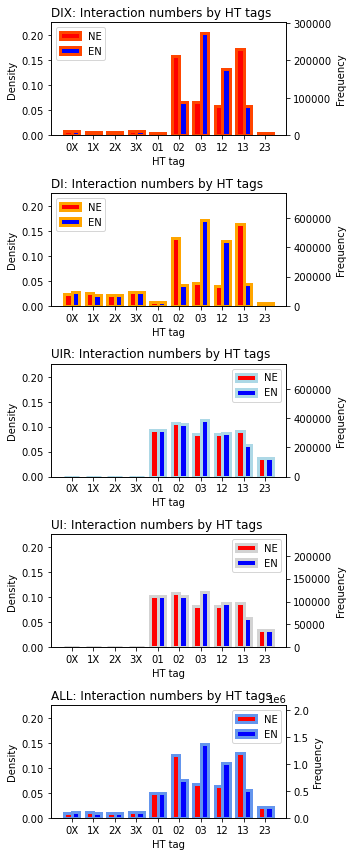

In [11]:
# Use this for CHC data
get_ht_tag_bar_chart_for_two_e_cats(
    ht_tag_freq_dict = HT_TAG_FREQ_DICT,
    e_cat_1 = 'NE',
    e_cat_2 = 'EN',
    e_cat_1_color = 'red',
    e_cat_2_color = 'blue',
    i_cats = ['DIX', 'DI', 'UIR', 'UI', 'ALL'],
    pdf_file_name = OUT_PREFIX + '_NE_EN_' + 'ht_tag_barplot_for_two_e_cats.pdf'
    )

For Hi-C data, it makes no sense to compare `NE` and `EN`. With data one would prefer to summarize all enrichment categories, i.e., not a grouped bar chart, but only one bar for each HT tag. But for now, we use the same function and pass the same enrichment category twice.

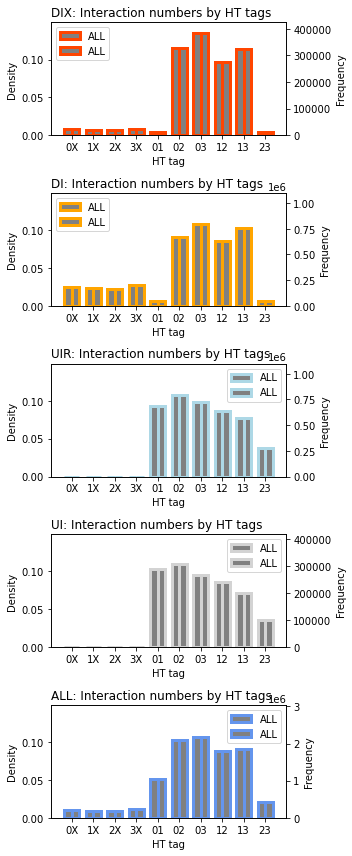

In [13]:
# Use this for HC datasets
get_ht_tag_bar_chart_for_two_e_cats(
    ht_tag_freq_dict = HT_TAG_FREQ_DICT,
    e_cat_1 = 'ALL',
    e_cat_2 = 'ALL',
    e_cat_1_color = 'gray',
    e_cat_2_color = 'gray',
    i_cats = ['DIX', 'DI', 'UIR', 'UI', 'ALL'],
    pdf_file_name = OUT_PREFIX + '_ALL_ALL_' + 'ht_tag_barplot_for_two_e_cats.pdf'
    )

ToDo
- Write extra function for Hi-C data with only one gray bar for each `HT` tag representing `ALL` enrichment categories.
- The HT frequencies could be normalized to the corresponding background distribution of the four read pair count types. For instance for 02, one could use `(S1+S2+T1+T2)/2*(S1+T1)` as normalization factor.

In [10]:
# Some statistics on HT tags with four or three equal counts:
# In such cases, the assignment of HT tag to interaction is ambigious.
# Here it is counted how often such cases occur.

INTERACTION_FILE = '/Users/hansep/PycharmProjects/diachrscripts/DICer_interactions/HT/FDR001/CHC/JAV_MAC_M0_RALT_20000_ht_fdr0.01_evaluated_and_categorized_interactions.tsv.gz'
d_inter_set = DiachromaticInteractionSet(rpc_rule='ht')
d_inter_set.parse_file(i_file=INTERACTION_FILE, verbose=True)

n_total = 0
nxxxx_total = 0
n0x_a_total = 0
n1x_a_total = 0
n2x_a_total = 0
n3x_a_total = 0
n0x_b_total = 0
n1x_b_total = 0
n2x_b_total = 0
n3x_b_total = 0
for d_inter in d_inter_set.interaction_list:
    n_total += 1
    if d_inter._simple_1 == d_inter._simple_2 and  d_inter._simple_2 == d_inter._twisted_1 and d_inter._twisted_1 == d_inter._twisted_2: # All four counts equal
        nxxxx_total += 1
    elif d_inter._simple_2 == d_inter._twisted_1 and d_inter._twisted_1 == d_inter._twisted_2: # 0X -> could be 01, 02, 03
        if d_inter._simple_1 > d_inter._simple_2:
            n0x_a_total += 1
            #print(str(d_inter._simple_1) + ':' + str(d_inter._simple_2) + ':' + str(d_inter._twisted_1) + ':' + str(d_inter._twisted_2) + ' -> ' + d_inter.get_ht_tag())
        else:
            n0x_b_total += 1
    elif d_inter._simple_1 == d_inter._twisted_1 and d_inter._twisted_1 == d_inter._twisted_2: # 1X -> could be 01, 12, 13
        if  d_inter._simple_2 > d_inter._twisted_1:
            n1x_a_total += 1
            #print(str(d_inter._simple_1) + ':' + str(d_inter._simple_2) + ':' + str(d_inter._twisted_1) + ':' + str(d_inter._twisted_2) + ' -> ' + d_inter.get_ht_tag())
        else:
            n1x_b_total += 1
    elif d_inter._simple_1 == d_inter._simple_2 and d_inter._simple_2 == d_inter._twisted_2: # 2X -> could be 02, 12, 23
        if d_inter._twisted_1 > d_inter._twisted_2:
            n2x_a_total += 1
            #print(str(d_inter._simple_1) + ':' + str(d_inter._simple_2) + ':' + str(d_inter._twisted_1) + ':' + str(d_inter._twisted_2) + ' -> ' + d_inter.get_ht_tag())
        else:
            n2x_b_total += 1
    elif d_inter._simple_1 == d_inter._simple_2 and d_inter._simple_2 == d_inter._twisted_1: # 3X -> could be 03, 13, 23
        if d_inter._twisted_2 > d_inter._twisted_1:
            n3x_a_total += 1
            #print(str(d_inter._simple_1) + ':' + str(d_inter._simple_2) + ':' + str(d_inter._twisted_1) + ':' + str(d_inter._twisted_2) + ' -> ' + d_inter.get_ht_tag())
        else:
            n3x_b_total += 1
    else:
        pass

print()
print("Total number of interactions: " + str(n_total))
print()
print("All four counts equal")
print("XX: " + str(nxxxx_total))
print("Three counts equal and smaller than the fourth count")
print("0XA: " + str(n0x_a_total))
print("1XA: " + str(n1x_a_total))
print("2XA: " + str(n2x_a_total))
print("3XA: " + str(n3x_a_total))
print("Three counts equal and greater than the fourth count")
print("0XB: " + str(n0x_b_total))
print("1XB: " + str(n1x_b_total))
print("2XB: " + str(n2x_b_total))
print("3XB: " + str(n3x_b_total))
print("All cases together")
nxx_total = n0x_a_total + n1x_a_total + n2x_a_total + n3x_a_total
nxx_total = nxx_total + n0x_b_total + n1x_b_total + n2x_b_total + n3x_b_total
nxx_total = nxx_total + nxxxx_total
print("XX: " + str(nxx_total))
print("Proportion of XX: " + str(nxx_total/n_total))

# Conclusion:
# The cases with four or three equal counts are rare (<4%) and should not have a significant impact on the results.

[INFO] Parsing Diachromatic interaction file ...
	[INFO] /Users/hansep/PycharmProjects/diachrscripts/DICer_interactions/HT/FDR001/CHC/JAV_MAC_M0_RALT_20000_ht_fdr0.01_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Parsed 2,000,000 interaction lines ...
	[INFO] Parsed 3,000,000 interaction lines ...
	[INFO] Parsed 4,000,000 interaction lines ...
	[INFO] Parsed 5,000,000 interaction lines ...
	[INFO] Parsed 6,000,000 interaction lines ...
	[INFO] Set size: 6,150,840
[INFO] ... done.

Total number of interactions: 6150840

All four counts equal
XX: 3930
Three counts equal and smaller than the fourth count
0XA: 38470
1XA: 36228
2XA: 39121
3XA: 35278
Three counts equal and greater than the fourth count
0XB: 16716
1XB: 16934
2XB: 16318
3XB: 16714
All cases together
XX: 219709
Proportion of XX: 0.03572016179903883
